# Hyperparameter Tuning with GridSearchCV

The [King County Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.  The model will predict house price.

Hyperparameters will be optimized.

### Common Imports and Notebook Setup

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Prior Notebook Setup
As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb)

In [25]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)

# compute mean sales price per house
mean_price_by_id = all_data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
all_data = all_data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

# drop original price and de-dup the records
all_data = all_data.drop('price_orig', axis=1).drop_duplicates(subset='id')

# remove id and date fields
all_data = all_data.drop(['id', 'date'], axis=1)

# repace yr_built with yr_renovated if yr_renovated != 0
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']
all_data = all_data.drop('yr_renovated',axis=1)

all_data = all_data.drop(['zipcode'], axis=1)

X_all = all_data.drop('price_mean', axis=1)
y_all = all_data['price_mean']
print(X_all.shape)
print(y_all.shape)

(21436, 16)
(21436,)


### Dask and DASK-ML
Searching through hyperparameter space is time consuming and embarassingly parallel.  Use Dask and DASK-ML to efficient parallelize the computations.  This is optional.

Here Dask will only be used for finding hyperparameters more quickly.  My computing setup is 2 desktop computers, each with 4 physical cores and hyperthreading.  Again, Dask specific commands can be ignored.

In [26]:
# Dask Specific Setup
import dask_ml.joblib
from sklearn.externals.joblib import parallel_backend

from dask.distributed import Client
try:
    client.close()
except:
    print('client was not open')
client = Client('hawaii:8786')
client

Client Scheduler: tcp://hawaii:8786 Dashboard: http://hawaii:8787/status,Cluster Workers: 2 Cores: 8 Memory: 67.45 GB


In [27]:
# custom RMSE scorer
from sklearn.metrics import make_scorer

def my_score(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)*(y-y_pred)))

my_rmse = make_scorer(my_score, greater_is_better=False)

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(oob_score=True)
rf.fit(X_all, y_all)
pred = rf.predict(X_all)
np.sqrt(np.mean((y_all-pred)*(y_all-pred)))

/home/agni/anaconda3/envs/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


59952.78814553296

In [13]:
rf.oob_score_

0.7585851134576407

In [7]:
s = pd.Series(data=rf.feature_importances_, index=X_all.columns)

bedrooms         0.003190
bathrooms        0.006963
sqft_living      0.274340
sqft_lot         0.017594
floors           0.002300
waterfront       0.029088
view             0.010695
condition        0.003365
grade            0.315961
sqft_above       0.022782
sqft_basement    0.006625
yr_built         0.014285
lat              0.168305
long             0.079671
sqft_living15    0.031434
sqft_lot15       0.013403
dtype: float64

In [29]:
# custom RMSE scorer
from sklearn.metrics import make_scorer

def my_score(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)*(y-y_pred)))

my_rmse = make_scorer(my_score, greater_is_better=False)

In [30]:
rf = RandomForestRegressor()
k_folds=10
cv = RepeatedKFold(n_splits=10, n_repeats=20, random_state=9)

start = time()
with parallel_backend('dask.distributed', scheduler_host='hawaii:8786'):
    
    # compute the K cross validated scores
    scores = cross_val_score(rf, X_all, y_all, cv=cv, n_jobs=1,
                     scoring=my_rmse)
print(f'Total Time: {time() - start}')

Total Time: 29.669833660125732


In [42]:
np.mean(scores)

-133188.61108440493

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

In [17]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)

# compute mean sales price per house
mean_price_by_id = all_data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
all_data = all_data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

# drop original price and de-dup the records
all_data = all_data.drop('price_orig', axis=1).drop_duplicates(subset='id')

# remove id and date fields
all_data = all_data.drop(['id', 'date'], axis=1)

# repace yr_built with yr_renovated if yr_renovated != 0
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']
all_data = all_data.drop('yr_renovated',axis=1)

all_data = all_data.drop(['zipcode'], axis=1)

X_all = all_data.drop('price_mean', axis=1)
y_all = all_data['price_mean']
print(X_all.shape)
print(y_all.shape)

(21436, 16)
(21436,)


In [18]:
# Dask Specific Setup
import dask_ml.joblib
from sklearn.externals.joblib import parallel_backend

from dask.distributed import Client
try:
    client.close()
except:
    print('client was not open')
client = Client('hawaii:8786')
client

client was not open


Client Scheduler: tcp://hawaii:8786 Dashboard: http://hawaii:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [23]:
X_all.sample()

bedrooms         21436
bathrooms        21436
sqft_living      21436
sqft_lot         21436
floors           21436
waterfront       21436
view             21436
condition        21436
grade            21436
sqft_above       21436
sqft_basement    21436
yr_built         21436
lat              21436
long             21436
sqft_living15    21436
sqft_lot15       21436
dtype: int64

In [5]:
# custom RMSE scorer
from sklearn.metrics import make_scorer

def my_score(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)*(y-y_pred)))

my_rmse = make_scorer(my_score, greater_is_better=False)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from time import time

In [6]:
from dask.distributed import Lock
def my_predict(estimator, X_train, X_test, y_train, y_test, lock):
    
    # avoid sklearn multithreaded bug
    rf = RandomForestRegressor(max_features=5, n_estimators=20, n_jobs=-1, random_state=9)

    # lock.acquire()
    rf.fit(X_train, y_train)
    # lock.release()
    predictions = rf.predict(X_test)
    
    return mean_squared_error(y_test, predictions)

In [9]:
# parallelize each train/test split
def my_cross_val_score(estimator, X, y, cv):
    
    my_scores = []
    future_predictions = []
    lock = Lock('x')
    for train_idx, test_idx in cv.split(X):

        # train
        X_train = X.iloc[train_idx, :]
        y_train = y[train_idx]
    
        # test
        X_test = X.iloc[test_idx, :]
        y_test = y[test_idx]
        
        future_predictions.append(client.submit(my_predict, estimator, X_train, X_test, y_train, y_test, lock))
        
    return np.array(client.gather(future_predictions))
    
#         my_scores.append(mean_squared_error(y_test, future_predictions))
        
#     return dask.compute(my_scores)

In [ ]:
# Learning Curve
# scale = StandardScaler()
rf = RandomForestRegressor(max_features=5, n_estimators=20, n_jobs=-1, random_state=9)
# min_samples_split=5, min_samples_leaf=3, max_depth=3, 

# pipe = Pipeline(steps=[('scale', scale),('rf',rf)])

k_folds=10
# cv = RepeatedKFold(n_splits=10, n_repeats=20, random_state=9)

np.random.seed(108)
df = pd.DataFrame()
counter=0

start = time()
X_all_f = client.scatter(X_all)
y_all_f = client.scatter(y_all)
X_all_f = X_all_f.result()
y_all_f = y_all_f.result()
with parallel_backend('dask.distributed', scheduler_host='hawaii:8786'):
# X_all_f = X_all
# y_all_f = y_all
    
    # 10 realizations of a subset of specific size to train and test on
    for i in range(10):
        print(f'Iteration: {i}')

        # 10 different sizes to train and test on
        for frac in np.linspace(0.2, 1.0, 9):
            print(f'Frac: {frac: 3.1f}')

            # select a random sample of frac size
            sample = all_data.sample(frac=frac, replace=False, random_state)
            X_all = all_data.drop('price_mean', axis=1)
            y_all = all_data['price_mean']            
            
            
            X_all_f = X_all_f.sample(frac=frac, replace=False, random_state = 10)
            n = int(frac*len(X_all_f))
            idx = np.random.choice(len(X_all_f), size=n, replace=False)
            X = X_all_f.iloc[idx]
            y = y_all_f.values[idx]

            # vary the number of folds
            for k_folds in [2, 3, 5, 10, 20]:
            # print(f'K: {k_folds}')

                # repeat CV 10 times to reduce the variance of the estimate
                cv = KFold(n_splits=k_folds, random_state=10+i)

                # compute the K cross validated scores
                scores = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)

                rmse = scores.mean()
                std_value = scores.std()

                # accumulate the results
                df = df.append(pd.DataFrame(data=[[k_folds, n, rmse, std_value]], 
                                            columns=['k_fold', 'len', 'rmse', 'std_value']),
                               ignore_index=True)
                

print(f'Total Time: {time() - start}')

Iteration: 0
Frac:  0.2
Frac:  0.3
Frac:  0.4
Frac:  0.5
Frac:  0.6
Frac:  0.7
Frac:  0.8
Frac:  0.9
Frac:  1.0
Iteration: 1
Frac:  0.2
Frac:  0.3
Frac:  0.4
Frac:  0.5
Frac:  0.6
Frac:  0.7
Frac:  0.8
Frac:  0.9
Frac:  1.0
Iteration: 2
Frac:  0.2
Frac:  0.3
Frac:  0.4
Frac:  0.5
Frac:  0.6
Frac:  0.7
Frac:  0.8
Frac:  0.9
Frac:  1.0
Iteration: 3
Frac:  0.2
Frac:  0.3
Frac:  0.4
Frac:  0.5
Frac:  0.6
Frac:  0.7
Frac:  0.8
Frac:  0.9
Frac:  1.0
Iteration: 4
Frac:  0.2
Frac:  0.3
Frac:  0.4
Frac:  0.5
Frac:  0.6
Frac:  0.7
Frac:  0.8
Frac:  0.9
Frac:  1.0


In [11]:
df.head(6)

,k_fold,len,rmse,std_value
0,2,4287,0.806112,0.000890
1,3,4287,0.820691,0.017632
2,5,4287,0.828745,0.020393
3,10,4287,0.827195,0.022065
4,20,4287,0.824834,0.034708
5,2,6430,0.812203,0.011848


In [12]:
# df_save = df.copy()
df_save.head(6)

,k_fold,len,rmse,std_value
0,2,4287,0.806112,0.000890
1,3,4287,0.820691,0.017632
2,5,4287,0.828745,0.020393
3,10,4287,0.827195,0.022065
4,20,4287,0.824834,0.034708
5,2,6430,0.812203,0.011848


In [17]:
client.scheduler_info()['workers'].keys()

dict_keys(['tcp://127.0.0.1:34269', 'tcp://192.168.168.186:41265'])

In [14]:
def mappable_cv(kwargs):
    """mappable wrapper to unpack kwargs and pass them to cross_val_score"""
    # import f
    return cross_val_score(**kwargs)

In [17]:
from sklearn.base import clone

# Learning Curve
scale = StandardScaler()
rf = RandomForestRegressor(max_features=5, n_estimators=20, n_jobs=1)
# min_samples_split=5, min_samples_leaf=3, max_depth=3, 

pipe = Pipeline(steps=[('scale', scale),('rf',rf)])

k_folds=10
# cv = RepeatedKFold(n_splits=10, n_repeats=20, random_state=9)

np.random.seed(108)
df = pd.DataFrame()
counter=0

start = time()

# 10 different sizes to train and test on
for frac in [1]: # np.linspace(0.2, 1.0, 9):
    print(f'Frac: {frac: 3.1f}')
    
    # 10 realizations of a subset of specific size to train and test on
    for i in range(10):
        print(f'Iteration: {i}')

        # select a random sample of frac size
        n = int(frac*len(X_all))
        idx = np.random.choice(len(X_all), size=n, replace=False)
        X = X_all.iloc[idx]
        y = y_all.values[idx]
        
        # turn list of values for a single kwarg into a list of kwarg dicts
        k_list = [2, 3, 5, 10, 20]
        kwarg_list = [ dict(estimator=clone(rf), 
                            X=X, 
                            y=y,
                            cv = KFold(n_splits=k, random_state=10+i),
                            scoring = my_rmse) for k in k_list ]
        
        future_scores = []
        if i % 2:
            # 1, 3, 5, ..
            future_scores.extend(client.map(mappable_cv, kwarg_list, workers=['127.0.0.1:34269']))
            print("about to block ...")
            client.gather(future_scores)
            print("done blocking ....")
        else:
            # 0, 2, 4, ...
            future_scores = client.map(mappable_cv, kwarg_list, workers=['192.168.168.186:41265'])

#         # compute the K cross validated scores
#         scores = cross_val_score(rf, X, y, cv=cv, n_jobs=-1, scoring=my_rmse)

#         rmse = scores.mean()
#         std_value = scores.std()

#         # accumulate the results
#         df = df.append(pd.DataFrame(data=[[k_folds, n, rmse, std_value]], 
#                                     columns=['k_fold', 'len', 'rmse', 'std_value']),
#                        ignore_index=True)
                

print(f'Total Time: {time() - start}')

Frac:  1.0
Iteration: 0
Iteration: 1
about to block ...


IndexError: pop from empty list

In [18]:
for i in range(10):
    if i % 2:
        print(i)

1
3
5
7
9


In [67]:
df_save = df.copy()

In [61]:
# group by K and Number of Records in Preparation
# for plotting the Learning Curve
rmse_data = df.groupby(['k_fold', 'len'])['rmse'].size()
rmse_data.head(11)

k_fold  len  
2       4287     10
        6430     10
        8574     10
        10718    10
        12861    10
        15005    10
        17148    10
        19292    10
        21436    10
3       4287     10
        6430     10
Name: rmse, dtype: int64

In [62]:
rmse_data = df.groupby(['k_fold', 'len'])['rmse'].mean()
rmse_data.head(11)

k_fold  len  
2       4287    -173234.543817
        6430    -157123.533648
        8574    -154244.804212
        10718   -151741.403035
        12861   -147793.442438
        15005   -145047.209200
        17148   -144560.171292
        19292   -144067.853726
        21436   -142280.356008
3       4287    -165423.147248
        6430    -151699.019940
Name: rmse, dtype: float64

In [63]:
rmse_data.loc[5].values

array([-162180.13196757, -148465.13929468, -147223.81318424,
       -143952.32343749, -141076.65033234, -140600.95980026,
       -138426.31414948, -136788.89726546, -136262.29300399])

In [64]:
rmse_data.loc[2].values

array([-173234.54381667, -157123.53364765, -154244.8042119 ,
       -151741.40303503, -147793.44243819, -145047.20920022,
       -144560.17129203, -144067.85372551, -142280.35600754])

In [54]:
rmse_data.loc[2].index.values

array([ 4287,  6430,  8574, 10718, 12861, 15005, 17148, 19292, 21436])

Text(0.5,1,'Learning Curve')

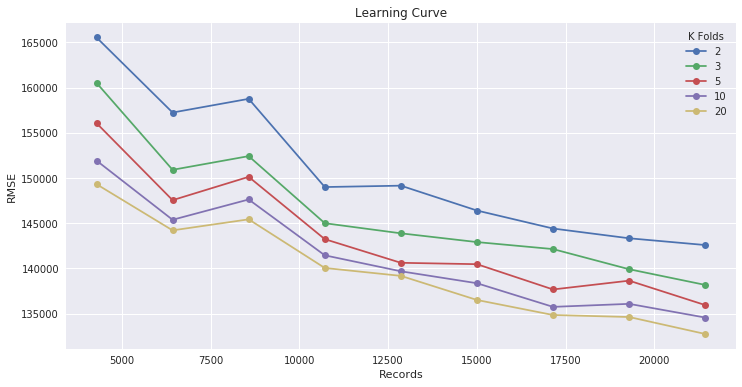

In [7]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

rmse_data = df.groupby(['k_fold','len'])['rmse'].mean()
for k in [2, 3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, -rmse_data.loc[k].values, marker='o', label=k)

plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.title('Learning Curve')

Text(0.5,1,'Learning Curve')

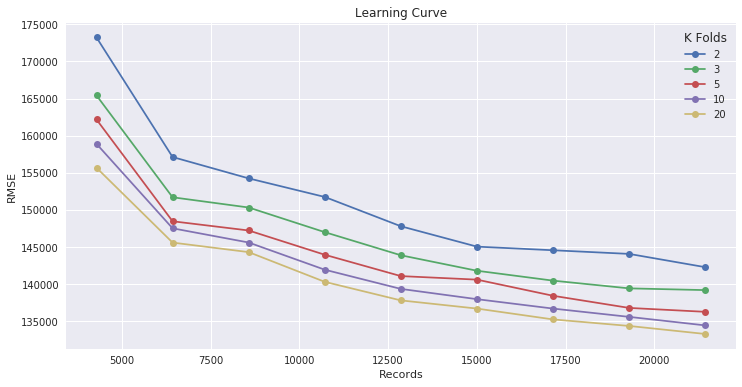

In [65]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))

rmse_data = df.groupby(['k_fold','len'])['rmse'].mean()
for k in [2, 3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, -rmse_data.loc[k].values, marker='o', label=k)

plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.title('Learning Curve')

In [13]:
len(X_all)

21436

In [12]:
# the only dask command is: with parallel_backend ...
start = time()
with parallel_backend('dask.distributed', scheduler_host='192.168.168.67:8786'):
    grid.fit(X_all, y_all)
    # scores = cross_val_score(grid, X_all, y_all, cv=3)
    
print(f'GridSearchCV Time: {time() - start: 5.1f} seconds')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.5s


GridSearchCV Time:  35.0 seconds


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   34.9s finished


### GridSearchCV Results
The results for the cross validated grid search are stored in grid.cv_results_. As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb) computing the correct RMSE and standard deviation of the RMSE requires access to the individual cross validated scores.

### Helper Functions to get Data from grid.cv_results
cross_val_score returns an array of values, one per fold.  GridSearchCV does not, however this form easiest to work with.  The following helper functions will reorganize cv_results_ to create a multidimensional array of values.

The dimensions of the array will be:
* K of KFold
* n_components of PCA
* weighting strategy for KNN Regression
* n_neighbors for KNN

In [13]:
# find the dictionary keys to access each CV fold
def get_test_score_keys(grid):
    keys = []
    for key in grid.cv_results_.keys():
        if 'split' in key and 'test' in key:
            keys.append(key)
    return keys

In [14]:
# keys for K fold test scores
get_test_score_keys(grid)

['split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score']

In [15]:
# paramter grid passed in
grid.param_grid

{'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'knn__n_neighbors': [1, 5, 10, 20],
 'knn__weights': ['uniform', 'distance']}

In [16]:
# GridSearchCV places the results in alphabetical order of paramter name
grid.cv_results_['params'][:10]

[{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 1},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 2},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 3},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 4},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 5},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 6},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 7},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 8},
 {'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 9},
 {'knn__n_neighbors': 1, 'knn__weights': 'distance', 'pca__n_components': 1}]

In [17]:
# Get the dimensions of the parameter grid
def get_dim(grid):
    dims = []
    for key in sorted(grid.param_grid.keys()):
        dims.append(len(grid.param_grid[key]))
    return tuple(dims)

In [18]:
# dimensions of parameter grid
get_dim(grid)

(4, 2, 9)

These dimensions match what is seen above for grid.cv_results_\['params'\]

In [19]:
# convert the CV test scores to an array
def get_test_data(grid):
    dim = get_dim(grid)
    new_dim = (grid.cv.get_n_splits(), *dim)

    result = np.zeros(new_dim)
    for i, key in enumerate(get_test_score_keys(grid)):
        data = np.array(grid.cv_results_[key])
        data = data.reshape(dim)
        result[i] = data

    return result

In [20]:
# There are 5 (4,2,9) CV test scores
get_test_data(grid).shape

(5, 4, 2, 9)

In [21]:
# verify the helper functions work properly

# compute mean test score using numpy array
test_data = get_test_data(grid)
mean_scores = test_data.mean(axis=0)
print(mean_scores.shape)

# retrieve mean test score from cv_results_
mean_scores2 = grid.cv_results_['mean_test_score']
mean_scores2 = mean_scores2.reshape(get_dim(grid))

# verify that every value is (almost) the same
print(np.allclose(mean_scores, mean_scores2, rtol=2e-5))

(4, 2, 9)
True


Helper methods produced same result.

In [22]:
# verify the helper functions work properly for std as well

test_data = get_test_data(grid)
std_scores = test_data.std(axis=0)
print(std_scores.shape)

std_scores2 = grid.cv_results_['std_test_score']
std_scores2 = std_scores2.reshape(get_dim(grid))
print(np.allclose(std_scores, std_scores2, rtol=6e-5))

(4, 2, 9)
True


As per [Cross Validation: W and W/O cross_val_score](http://nbviewer.jupyter.org/github/sdiehl28/tutorial-jupyter-notebooks/blob/master/projects/king_county/CV_Pipeline.ipynb) in the section RMSE Computation.

It is not possible to get RMSE and standard deviation of RMSE, from cv_results_ 'mean_test_score' and 'std_test_score' as these vaules are based on MSE, not RMSE.

In [23]:
# compute RMSE
test_data = get_test_data(grid)
rmse_scores = np.sqrt(np.abs(test_data)).mean(axis=0)

# compute standard deviation of RMSE
std_scores = np.sqrt(np.abs(test_data)).std(axis=0)

### Examine Hyperparameter Space
Create 2 2D arrays, one for each weighting scheme.

Examine each 2D array as heatmap to see where the best model performance is.

In [24]:
# split out the uniformly weighted from the distance weighted mean of the K target values
rmse_uniform = rmse_scores[:,0,:]
rmse_dist    = rmse_scores[:,1,:]
std_uniform   = std_scores[:,0,:]
std_dist      = std_scores[:,1,:]
print(rmse_uniform.shape)

(4, 9)


Text(0.5,1,'RMSE Uniform Weighting')

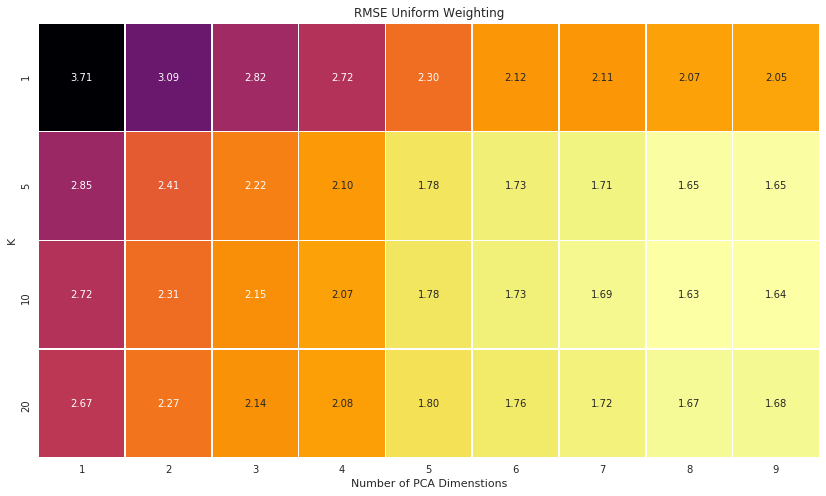

In [25]:
# scale so annotation on plot is more readable
df = pd.DataFrame(data=rmse_uniform/1e5, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('RMSE Uniform Weighting')

Text(0.5,1,'RMSE Distance Weighting')

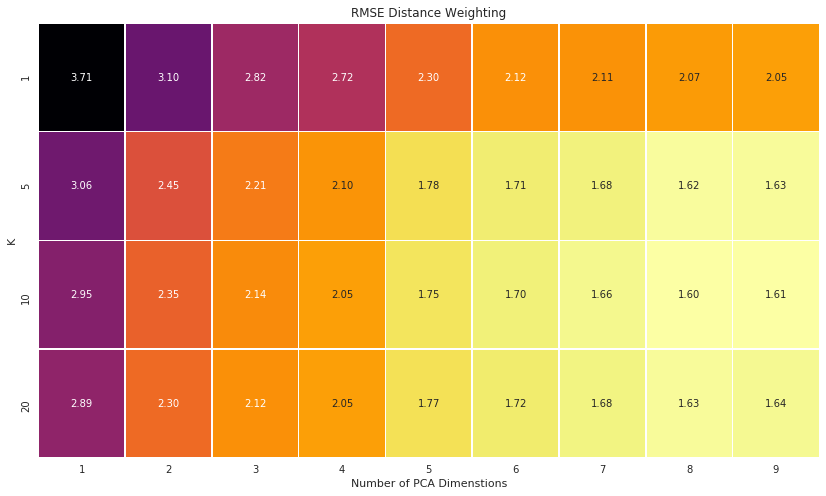

In [26]:
# scale so annotation on plot is more readable
df = pd.DataFrame(data=rmse_dist/1e5, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('RMSE Distance Weighting')

Text(0.5,1,'Standard Devation of RMSE Uniform Weighting')

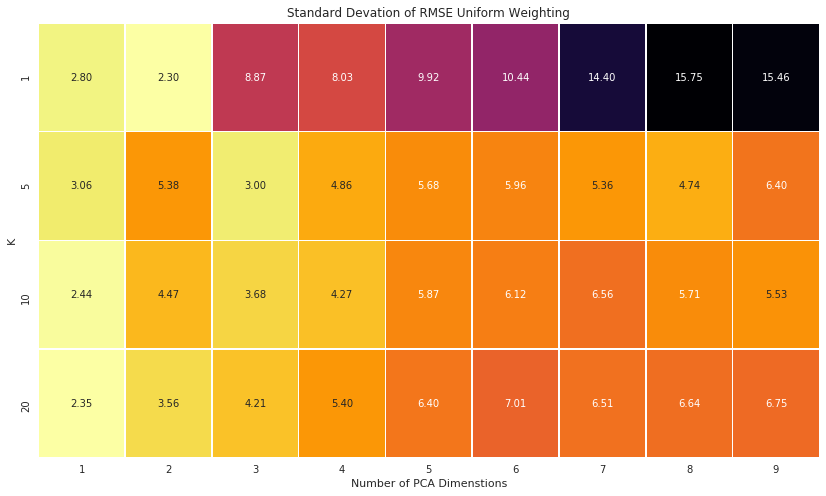

In [27]:
# scale to annotation on plot is more readable
df = pd.DataFrame(data=std_uniform/1e3, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('Standard Devation of RMSE Uniform Weighting')

Text(0.5,1,'Standard Devation of RMSE Distance Weighting')

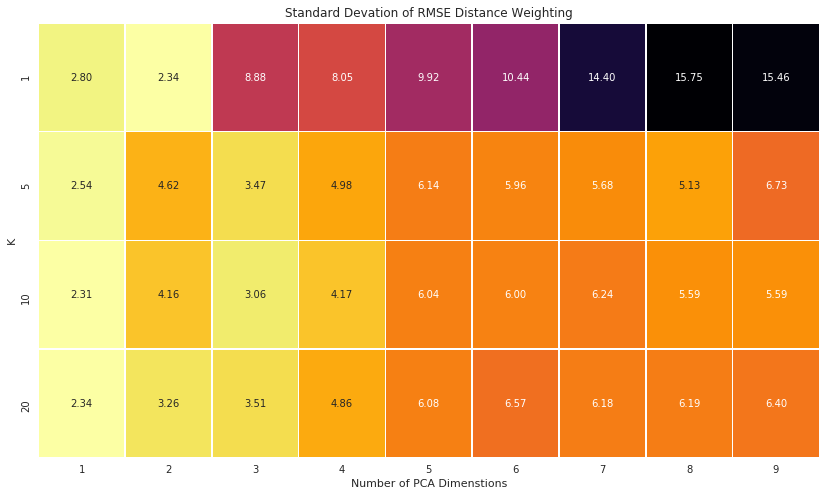

In [28]:
# scale to annotation on plot is more readable
df = pd.DataFrame(data=std_dist/1e3, columns=n_components, index=n_neighbors)
plt.figure(figsize=(14,8))
sns.heatmap(df, linewidth=0.5, annot=True, cmap='inferno_r',fmt='4.2f', cbar=False)
plt.xlabel('Number of PCA Dimenstions')
plt.ylabel('K')
plt.title('Standard Devation of RMSE Distance Weighting')

Best score was (10, distance, 8).  Compute these again with cross_val_score() to verify results.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(weights='distance', n_neighbors=10)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict cv generator for repeatability
k_folds = 5
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

# with parallel_backend('dask.distributed', scheduler_host='192.168.168.67:8786'):
scores = cross_val_score(pipe, X_all, y_all, cv=cv, 
                             scoring='neg_mean_squared_error', n_jobs=1)

# RMSE
rmse = np.sqrt(np.abs(scores)).mean()
rmse

160024.18177278718

In [30]:
# verify the rmse scores computed above match
print(grid.param_grid['knn__n_neighbors'][2])
print(grid.param_grid['knn__weights'][1])
print(grid.param_grid['pca__n_components'][7])

# RMSE for K = 10, weight = distance, PCA components = 8
rmse_scores[2,1,7]
print(np.allclose(rmse, rmse_scores[2,1,7]))

10
distance
8
True


### Analysis of Results
Put that here ...
Refere to LearningCurve and BiasCorrection nb